In [3]:
# xarray to read NETCDF
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
CanESM5 = xr.open_mfdataset('data/NMME/CanESM5/*.nc')
CanESM5_south_sudan = (CanESM5.sel(Y=slice(3.5, 12.5), X=slice(25, 35))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'})
                       .groupby(['latitude', 'longitude', 'date of prediction', 'lead time'])
                       .mean('M'))

In [5]:
CanESM5_south_sudan_df = CanESM5_south_sudan.to_dataframe().reset_index()
CanESM5_south_sudan_df['time'] = CanESM5_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)
CanESM5_south_sudan_df

,latitude,longitude,date of prediction,lead time,predicted precip,time
0,4.0,25.0,1991-01-01,0.5,1.467990,1991-01-01
1,4.0,25.0,1991-01-01,1.5,2.146416,1991-02-01
2,4.0,25.0,1991-01-01,2.5,4.841275,1991-03-01
3,4.0,25.0,1991-01-01,3.5,6.101315,1991-04-01
4,4.0,25.0,1991-01-01,4.5,7.684224,1991-05-01
...,...,...,...,...,...,...
14251,12.0,35.0,1991-12-01,7.5,9.475497,1992-07-01
14252,12.0,35.0,1991-12-01,8.5,7.460325,1992-08-01
14253,12.0,35.0,1991-12-01,9.5,6.143317,1992-09-01
14254,12.0,35.0,1991-12-01,10.5,3.131279,1992-10-01


In [7]:
chirps = xr.open_dataset('data/CHIRPS/chirps-v2.0.1991.monthly.nc')
chirps_south_sudan = (chirps.sel(latitude=slice(3.5, 12.5), 
                                longitude=slice(24, 36))
                      .interp_like(CanESM5_south_sudan, method='nearest'))

In [8]:
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()
chirps_south_sudan_df

,time,latitude,longitude,precip
0,1991-01-01,4.0,25.0,16.176336
1,1991-01-01,4.0,26.0,22.078163
2,1991-01-01,4.0,27.0,14.702608
3,1991-01-01,4.0,28.0,22.659842
4,1991-01-01,4.0,29.0,22.823318
...,...,...,...,...
1183,1991-12-01,12.0,31.0,0.166143
1184,1991-12-01,12.0,32.0,0.061604
1185,1991-12-01,12.0,33.0,0.082613
1186,1991-12-01,12.0,34.0,0.105609


In [9]:
CanESM5_south_sudan_df_clean = CanESM5_south_sudan_df.merge(chirps_south_sudan_df, on = ['latitude', 'longitude', 'time'], how = 'left').drop(['time', 'latitude', 'longitude'], axis = 1)
CanESM5_south_sudan_df_clean['month'] = CanESM5_south_sudan_df_clean['date of prediction'].dt.month
corr_clean = CanESM5_south_sudan_df_clean.drop('date of prediction', axis = 1).groupby(['month', 'lead time']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=2).reset_index()
corr_clean_1 = corr_clean.drop(corr_clean.index[::2])
corr_clean_1['predicted precip'] = corr_clean_1['predicted precip']
corr_clean_1

,month,lead time,predicted precip
1,1,0.5,0.811742
3,1,1.5,0.912284
5,1,2.5,0.886696
7,1,3.5,0.837231
9,1,4.5,0.773618
...,...,...,...
279,12,7.5,NaN
281,12,8.5,NaN
283,12,9.5,NaN
285,12,10.5,NaN


In [10]:
stat = (CanESM5_south_sudan_df_clean.drop('date of prediction', axis = 1)
        .groupby(['month', 'lead time']).agg(['mean', 'std']).reset_index())
stat.columns = stat.columns.droplevel()
stat.columns = ['month', 'lead time', 'pred mean', 'pred std', 'actual mean', 'actual std']
stat_clean = stat.merge(corr_clean_1.reset_index(), on = ['month', 'lead time'], how = 'left').drop("index", axis = 1)
stat_clean.columns = ['month', 'lead time', 'pred mean', 'pred std', 'actual mean', 'actual std', 'corr']
stat_clean['conditional bias'] = stat_clean.apply(lambda x: np.power(x['corr'] - x['pred std']/x['actual std'],2), axis = 1)
stat_clean['unconditional bias'] = stat_clean.apply(lambda x: np.power((x['pred mean'] - x['actual mean'])/x['actual std'],2), axis = 1)
stat_clean['potential skill'] = stat_clean.apply(lambda x: np.power(x['corr'],2), axis = 1)
stat_clean = stat_clean.drop(['corr','pred mean', 'pred std', 'actual mean', 'actual std'], axis = 1)
stat_clean['skill score'] = stat_clean.apply(lambda x: x['potential skill'] - x['conditional bias'] - x['unconditional bias'], axis = 1)
stat_clean

,month,lead time,conditional bias,unconditional bias,potential skill,skill score
0,1,0.5,0.591124,0.300686,0.658925,-0.232884
1,1,1.5,0.771972,0.427922,0.832262,-0.367632
2,1,2.5,0.718501,0.694609,0.786230,-0.626880
3,1,3.5,0.656288,1.165631,0.700955,-1.120964
4,1,4.5,0.551392,5.283461,0.598484,-5.236369
...,...,...,...,...,...,...
139,12,7.5,NaN,NaN,NaN,NaN
140,12,8.5,NaN,NaN,NaN,NaN
141,12,9.5,NaN,NaN,NaN,NaN
142,12,10.5,NaN,NaN,NaN,NaN


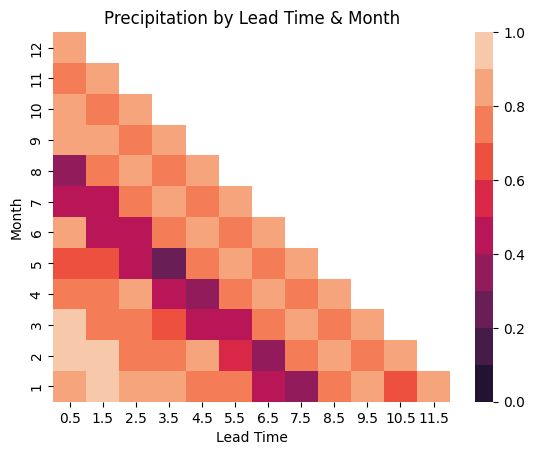

In [11]:
pivot_df = corr_clean_1.pivot_table(index = 'month', columns = 'lead time', values = 'predicted precip')
colormap = sns.color_palette('rocket', 10)
ax = sns.heatmap(pivot_df, vmin=0, vmax=1, cmap = colormap)
ax.invert_yaxis()
plt.title("Precipitation by Lead Time & Month")
plt.ylabel("Month")
plt.xlabel("Lead Time")
plt.show()